# Scott Wilcockson scRNA Data Analysis for Drosophila
This is a jupyter notebook to compare Scott Wilcockson single-cell RNA-seq data on __Drosophila__ germline stem cells and cytoblasts with Bulk data (I am not sure whether BULK is from the same cell line). A objective of the project is to find similarity between Bulk and Single-cell experiment. Rows A, B, C, D contain germline stem cells and Rows E, F, G and H contains cytoblasts.

Two reference papers that might help us in comparing single-cell data with Bulk data would be

* [Marinov et. al.](http://genome.cshlp.org/content/24/3/496.full)
* [Trapnell et. al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4122333/)


In [1]:
import subprocess, os, csv, signal, pysam, collections, optparse, sys, tempfile, re, optparse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pylab
import plotly
plotly.offline.init_notebook_mode() # run at the start of every ipython notebook
import readline
import rpy2.robjects

In [76]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
%load_ext rpy2.ipython

In [4]:
%%R
library(scde)
library(DESeq2)
library(ggplot2)
#library(made4)
library(irlba)
library(scater)
library(scran)
library(ComplexHeatmap)
library(genefilter)
library(ccRemover)
library(Rtsne)
library(plotly)
library(MASS)
library(M3Drop)
library(GGally)
library(monocle)
library(reshape)
library(corrplot)

## Preparing dataset
Below we preare the dataset for the downstream analysis

Reading the gene names of Drosophelia Genes

In [5]:
%%R
GeneName <- read.table("/home/baker/Rna-seq_Data-Analysis/Scott_Wilcockson_Single_cell_RNA/Drosophelia_genename.csv", row.names=1)

Reading the Bulkd data count files. I had to modify the count files as it had the no_features stats generated from the htseq tool. I removed those information as they are not needed for this analysis.

In [77]:
%%R
cdBulk <- read.csv('/home/baker/Rna-seq_Data-Analysis/Scott_Wilcockson_Single_cell_RNA/Htseq_Bulk_Modified.csv', row.names=1, sep=',')
cdBulkAnnot <- cdBulk
rownames(cdBulkAnnot) <- GeneName$V2
head(cdBulkAnnot)

               C1.TKVQD1 C2.TKVQD2 C3.Bau1 C4.Bau2 C5.GSC1 C6.GSC2 C7.CB1
7SLRNA:CR32864         0         3       4       1       4      47      2
a                    634       752     733     583     966     241    206
abd-A                 13         8      25      33      30       0     20
Abd-B               1519      2356     271     430    4542     957     15
Abl                 3127      3247    2628    2025    4514    1165    275
abo                  975      1008     842     784    1967    2024     85
               C8.CB2 SC.Merged.GSC SC.Merged.CB SC.Merged.Unknown
7SLRNA:CR32864     21             0            3                 0
a                  45           867         1250               114
abd-A               2             0            0                 0
Abd-B               7             0          120                 1
Abl                39           384          764                74
abo                73           978         3798               372


Normalizing the BULk data using the DESeq data and then we will take out the genes.

In [79]:
%%R
countsTable <- cdBulkAnnot

# rep replicates elements of vectors and lists, rep(x, times) or rep (x, lenght.out)
# c() combines values into a vector or list. This way a vector or matrix is created
# The function factor is used to encode a vector as a factor. In factor the integer values are labled with the values in labels
condition <- factor(c(rep("TKVQD",2),rep("BAU",2),rep("GSC",2),rep("CB",2), "SC.Merged.GSC", "SC.Merged.CB", "SC.Merged.Unknown"),
                    levels=c("TKVQD", "BAU", "GSC", "CB", "SC.Merged.GSC", "SC.Merged.CB", "SC.Merged.Unknown"),
                    labels = c("TKVQD", "BAU", "GSC", "CB","SC.Merged.GSC", "SC.Merged.CB", "SC.Merged.Unknown"))

# Creating the different sample names
myNames<-c("C1-TKVQD1", "C2-TKVQD2", "C3-Bau1", "C4-Bau2", "C5-GSC1", "C6-GSC2", "C7-CB1", "C8-CB2",
           "SC.Merged.GSC", "SC.Merged.CB", "SC.Merged.Unknown")

# Linking the samples with treatment name
colDataNames<-data.frame(sampleName=myNames, condition=condition)

# Creating the descriptor
des<-formula(~condition)
# ===================== end of R own code ===========================================================

# ===================== Start of DESeq2 =============================================================
# The DESeqDataSet is a subclass of SummarizedExperiment , used to store the input values, 
# intermediate calculations and results of an analysis of differential expression. The DESeqDataSet
# class enforces non-negative integer values in the "counts" matrix stored as the first element in 
# the assay list.  In addition, a formula which specifies the design of the experiment must be 
# provided.  The constructor functions create a DESeqDataSet object from various types of 
# input:  a SummarizedExperiment, a matrix, or count files generated by the python package HTSeq. 

# Reading the count table that was generated using htseq-count
ddsHTSeq <-DESeqDataSetFromMatrix(countsTable, colData=colDataNames, design=des, ignoreRank = FALSE)

# Running the actual DESeq program
ddsHTSeq<-DESeq(ddsHTSeq)

# Get normalised counts
normCounts<-as.data.frame(counts(ddsHTSeq,normalized=TRUE))
# The sampleFiles try to grep all the files that starts with the name mentioned with grep

# Sample condition is a 

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

estimating size factors


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

estimating dispersions


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

gene-wise dispersion estimates


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

mean-dispersion relationship


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

final dispersion estimates


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

fitting model and testing




In [80]:
%%R
cdBatchNorm <- normCounts
head(cdBatchNorm)

                 C1.TKVQD1   C2.TKVQD2    C3.Bau1      C4.Bau2     C5.GSC1
7SLRNA:CR32864    0.000000    2.138639    3.45792    0.7969128    1.453247
a               453.068962  536.085580  633.66386  464.6001705  350.959031
abd-A             9.290058    5.703038   21.61200   26.2981229   10.899349
Abd-B          1085.507498 1679.544717  234.27409  342.6725100 1650.161405
Abl            2234.616160 2314.720584 2271.85352 1613.7484481 1639.988680
abo             696.754319  718.582799  727.89219  624.7796461  714.633968
                 C6.GSC2      C7.CB1     C8.CB2 SC.Merged.GSC SC.Merged.CB
7SLRNA:CR32864  15.73206    8.112569 101.363277        0.0000     1.341022
a               80.66864  835.594643 217.207022      586.6235   558.759261
abd-A            0.00000   81.125693   9.653645        0.0000     0.000000
Abd-B          320.33150   60.844270  33.787759        0.0000    53.640889
Abl            389.95424 1115.478285 188.246086      259.8194   341.513660
abo            677.48272 

In [88]:
%%R
MappingSummary <- read.csv('/home/baker/Rna-seq_Data-Analysis/Scott_Wilcockson_Single_cell_RNA/MappingSummaryBulkAndMerged.csv', row.names=1)
head(MappingSummary)

            CellType
C1.TKVQD1 Bulk-TKVQD
C2.TKVQD2 Bulk-TKVQD
C3.Bau1     Bulk-Bau
C4.Bau2     Bulk-Bau
C5-GSC1     Bulk-GSC
C6-GSC2     Bulk-GSC


In [89]:
%%R
rowVarsSorted <- cdBatchNorm[order(rowVars(cdBatchNorm), decreasing=TRUE),]
FinalPCAData <- t(rowVarsSorted[1:500,])
#FinalPCAData <- t(rowVarsSorted)
pcaPRComp <- prcomp(FinalPCAData)

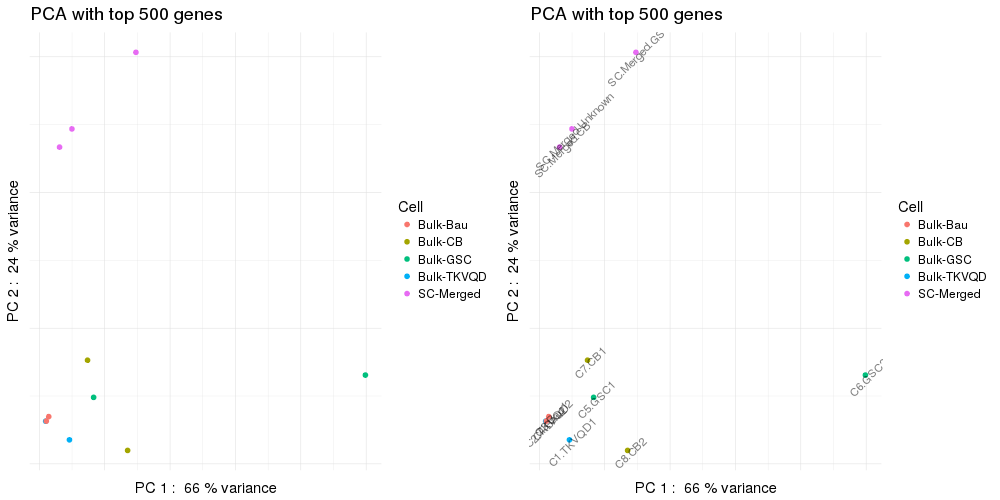

In [90]:
%%R -w 1000 -h 500
PCx=1
PCy=2
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
df$Cell=as.factor(MappingSummary$CellType)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with top 500 genes")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
#p <- p + geom_text(data=df,aes(label=colnames(exprs(cdSceset))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#p <- p + scale_colour_brewer(palette="Set1")

PCx=1
PCy=2
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
df$Cell=as.factor(MappingSummary$CellType)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with top 500 genes")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
p1<-p1 + geom_text(data=df,aes(label=rownames(df)),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#p1 <- p1 + scale_colour_brewer(palette="Set1")
multiplot(p,p1, cols=2)

### CPM normalization

In [92]:
%%R
DataInfo <- data.frame(Cell=colnames(cdBatchNorm), CellType=MappingSummary$CellType)
rownames(DataInfo) <- colnames(cdBatchNorm)
pd <- new("AnnotatedDataFrame", data = DataInfo)
rownames(pd) <- pd$Cell
cdSceset <- newSCESet(countData = cdBatchNorm, phenoData = pd)
cdSceset <- calculateQCMetrics(cdSceset)

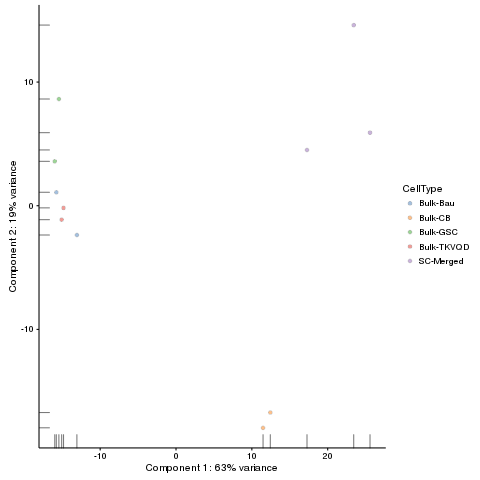

In [93]:
%%R
plotPCA(cdSceset, ncomponents = 2, colour_by = "CellType")

In [94]:
%%R
rowVarsSorted <- exprs(cdSceset)[order(rowVars(exprs(cdSceset)), decreasing=TRUE),]
FinalPCAData <- t(rowVarsSorted[1:500,])
#FinalPCAData <- t(rowVarsSorted)
pcaPRComp <- prcomp(FinalPCAData)

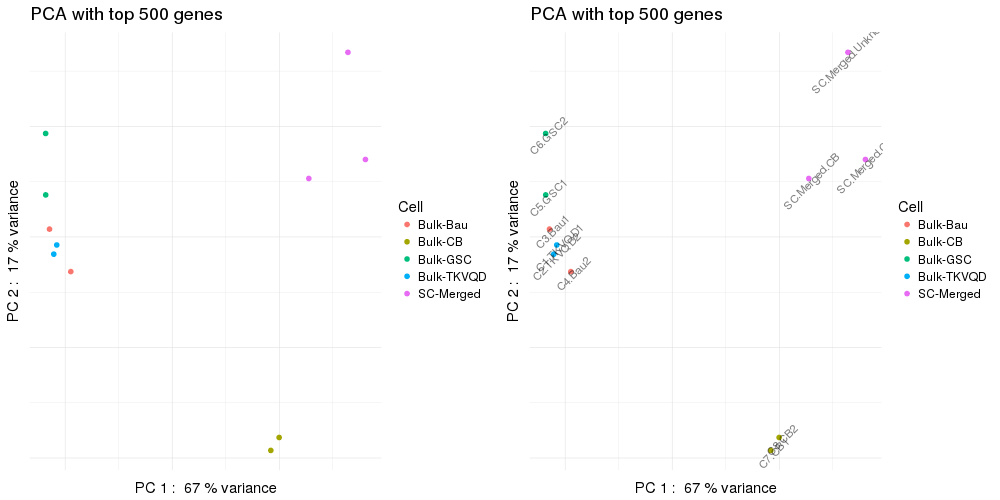

In [95]:
%%R -w 1000 -h 500
PCx=1
PCy=2
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
df$Cell=as.factor(MappingSummary$CellType)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with top 500 genes")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
#p <- p + geom_text(data=df,aes(label=colnames(exprs(cdSceset))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#p <- p + scale_colour_brewer(palette="Set1")

PCx=1
PCy=2
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
df$Cell=as.factor(MappingSummary$CellType)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with top 500 genes")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdSceset))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#p1 <- p1 + scale_colour_brewer(palette="Set1")
multiplot(p,p1, cols=2)

In [96]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

#pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1))
#rownames(pca_var_out) <- rownames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

 plot: [1,2] [======--------------------------------------------] 12% est: 1s 

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

 plot: [1,3] [=========-----------------------------------------] 19% est: 1s 

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

 plot: [1,4] [============--------------------------------------] 25% est: 1s 

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

 plot: [3,3] [==================================----------------] 69% est: 0s 



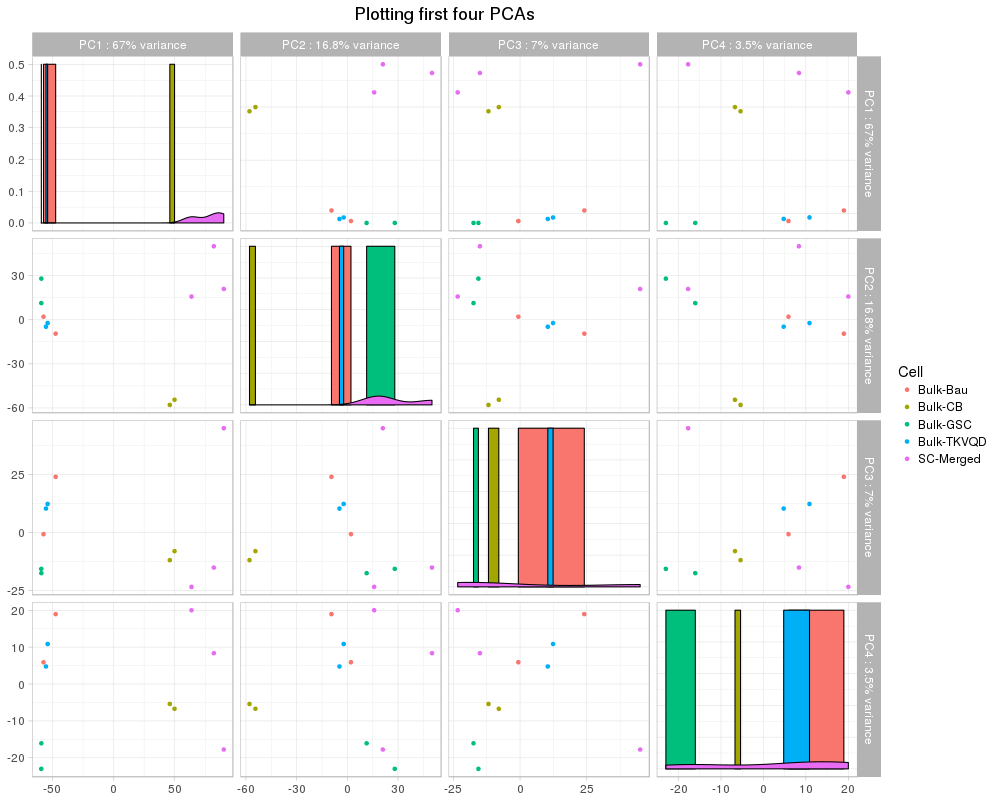

In [98]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=as.factor(MappingSummary$CellType)
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

### With All Genes

In [99]:
%%R
rowVarsSorted <- exprs(cdSceset)[order(rowVars(exprs(cdSceset)), decreasing=TRUE),]
#FinalPCAData <- t(rowVarsSorted[1:500,])
FinalPCAData <- t(rowVarsSorted)
pcaPRComp <- prcomp(FinalPCAData)

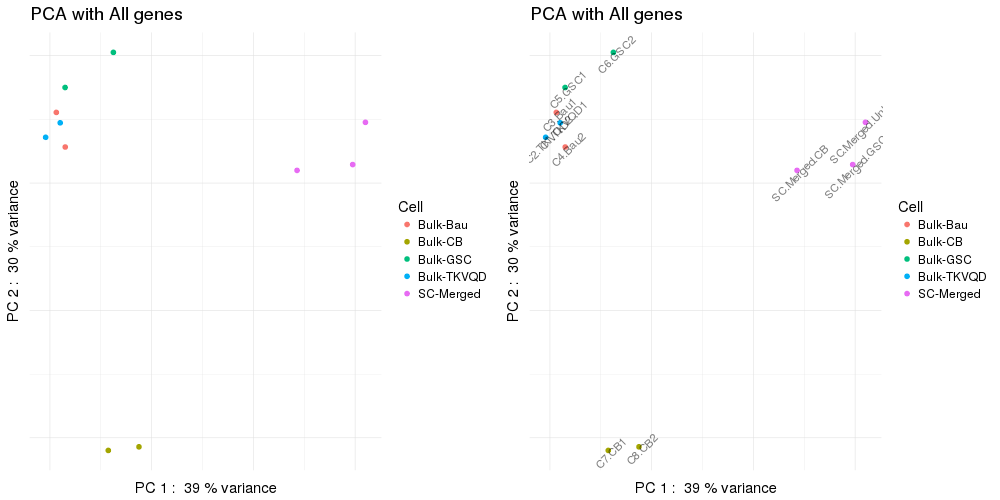

In [100]:
%%R -w 1000 -h 500
PCx=1
PCy=2
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
df$Cell=as.factor(MappingSummary$CellType)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with All genes")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
#p <- p + geom_text(data=df,aes(label=colnames(exprs(cdSceset))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#p <- p + scale_colour_brewer(palette="Set1")

PCx=1
PCy=2
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
df$Cell=as.factor(MappingSummary$CellType)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with All genes")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdSceset))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#p1 <- p1 + scale_colour_brewer(palette="Set1")
multiplot(p,p1, cols=2)

------------------------------
## Single-cell Analysis

In [9]:
%%R
cd <- read.csv('/home/baker/Rna-seq_Data-Analysis/Scott_Wilcockson_Single_cell_RNA/AllHtseqCounts_Scott_Modified.csv', row.names=1)
cdAnnot<-cd
rownames(cdAnnot) <- GeneName$V2
a <- gsub('^C','', colnames(cdAnnot))
a <- gsub('_[A-z]*[0-9]*','', a)
colnames(cdAnnot) <- a
#write.csv(cdAnnotAll,'/home/baker/Rna-seq_Data-Analysis/Amy_Adlard_scRNA/cdAnnotAll.csv')

In [10]:
%%R
cdAnnot <- cdAnnot [,-which(gsub('[0-9_S]','', colnames(cdAnnot)) == 'H')]
colnames(cdAnnot)

 [1] "A01" "A02" "A03" "A04" "A05" "A06" "A07" "A08" "A09" "A10" "A11" "A12"
[13] "B01" "B02" "B03" "B04" "B05" "B06" "B07" "B08" "B09" "B10" "B11" "B12"
[25] "C01" "C02" "C03" "C04" "C05" "C06" "C07" "C08" "C09" "C10" "C11" "C12"
[37] "D01" "D02" "D03" "D04" "D05" "D06" "D07" "D08" "D09" "D10" "D11" "D12"
[49] "E01" "E02" "E03" "E04" "E05" "E06" "E07" "E08" "E09" "E10" "E11" "E12"
[61] "F01" "F02" "F03" "F04" "F05" "F06" "F07" "F08" "F09" "F10" "F11" "F12"
[73] "G01" "G02" "G03" "G04" "G05" "G06" "G07" "G08" "G09" "G10" "G11" "G12"


### Cell Filtering
__This is a major step to remove the bad cells__

We will now filter the cells. We will still apply `scde::clean.counts` to filter out the bed cells. However, after filtering we will look at the previous figures so confirm whether they agree with our threshold and with our identification of bad cells

In [11]:
%%R
cdFiltered <- clean.counts(cdAnnot, min.lib.size = 1800, min.reads = 10,min.detected = 5)
print(paste("Before Filtering (genes): ", dim(cdAnnot)[1]))
print(paste("Before Filtering (Cells): ", dim(cdAnnot)[2]))
print(paste("After Filtering (genes): ", dim(cdFiltered)[1]))
print(paste("After Filtering (cells): ", dim(cdFiltered)[2]))

[1] "Before Filtering (genes):  17559"
[1] "Before Filtering (Cells):  84"
[1] "After Filtering (genes):  8367"
[1] "After Filtering (cells):  83"


In [12]:
%%R
print(colnames(cdAnnot))
print(colnames(cdFiltered))

 [1] "A01" "A02" "A03" "A04" "A05" "A06" "A07" "A08" "A09" "A10" "A11" "A12"
[13] "B01" "B02" "B03" "B04" "B05" "B06" "B07" "B08" "B09" "B10" "B11" "B12"
[25] "C01" "C02" "C03" "C04" "C05" "C06" "C07" "C08" "C09" "C10" "C11" "C12"
[37] "D01" "D02" "D03" "D04" "D05" "D06" "D07" "D08" "D09" "D10" "D11" "D12"
[49] "E01" "E02" "E03" "E04" "E05" "E06" "E07" "E08" "E09" "E10" "E11" "E12"
[61] "F01" "F02" "F03" "F04" "F05" "F06" "F07" "F08" "F09" "F10" "F11" "F12"
[73] "G01" "G02" "G03" "G04" "G05" "G06" "G07" "G08" "G09" "G10" "G11" "G12"
 [1] "A01" "A02" "A03" "A04" "A05" "A06" "A07" "A08" "A09" "A10" "A11" "B01"
[13] "B02" "B03" "B04" "B05" "B06" "B07" "B08" "B09" "B10" "B11" "B12" "C01"
[25] "C02" "C03" "C04" "C05" "C06" "C07" "C08" "C09" "C10" "C11" "C12" "D01"
[37] "D02" "D03" "D04" "D05" "D06" "D07" "D08" "D09" "D10" "D11" "D12" "E01"
[49] "E02" "E03" "E04" "E05" "E06" "E07" "E08" "E09" "E10" "E11" "E12" "F01"
[61] "F02" "F03" "F04" "F05" "F06" "F07" "F08" "F09" "F10" "F11" "F12" "G01"

So, after filtering it keeps 83 cells out of 84 cells.

Now from the Bulk data I will take out only the genes that are left in the single cell data after filtering.

In [13]:
%%R
#cdBulkAnnotFilt <- cdBatchNorm[rownames(cdBatchNorm) %in% rownames(cdFiltered), ]
cdBulkAnnotFilt <- cdBulkAnnot[rownames(cdBulkAnnot) %in% rownames(cdFiltered), ]
dim(cdBulkAnnotFilt)

[1] 8367    8


In [14]:
%%R
cdCombined <- cbind(cdFiltered,cdBulkAnnotFilt)

In [15]:
%%R
head(cdCombined)

         A01  A02  A03  A04 A05 A06  A07 A08  A09  A10 A11  B01  B02  B03 B04
a         65   44    0   17   0   1   78  14    6  200   2    9    0    0   0
Abl       24   92    7    2   0   1    0   0    3    0   0   17   60    0   0
abo        0    0    0  127   0  61    0   0   26    0 125   34    0    0   0
Acph-1   676  246  108  271   0  45   99  60   74  595 356  646 1632   79  87
mAChR-A    0    0    0    0   0   0    0   0    0    0   0    0    0    0   0
Act5C   1788 1505 1360 1650 906 311 1515 483 1275 1676 515 3273 2220 4149 384
        B05 B06 B07 B08 B09 B10  B11  B12  C01  C02 C03 C04 C05 C06 C07 C08 C09
a         0   0   2   9   2   0   13    0   23   37   0  25  10   7   0  39   0
Abl       6   0   3   1   0   0    9    0   24   29   7   0   1   0   0  22   0
abo      40   0  59   0   0   0   42    0  128  291   0   0   0  24   0   0  39
Acph-1   98  20  25  32  54   0  154  663  133  161  55  63  74  36  56 109  16
mAChR-A   0   0   0   0   0   0    6    0   16    0   

In [16]:
%%R
MappingSummary <- read.csv('/home/baker/Rna-seq_Data-Analysis/Scott_Wilcockson_Single_cell_RNA/MappingSummarySingleCellAndBulk.csv', row.names=1)
head(MappingSummary)

    CellType
A01  SC_Stem
A02  SC_Stem
A03  SC_Stem
A04  SC_Stem
A05  SC_Stem
A06  SC_Stem


---------------------
## Analysis
From this point onwards the analysis starts. Our objectvie is to compare the single-cell RNA-seq with the Bulk data.

In [17]:
%%R
DataInfo <- data.frame(Cell=colnames(cdCombined), CellType=MappingSummary$CellType)
rownames(DataInfo) <- colnames(cdCombined)
pd <- new("AnnotatedDataFrame", data = DataInfo)
rownames(pd) <- pd$Cell
cdSceset <- newSCESet(countData = cdCombined, phenoData = pd)
cdSceset <- calculateQCMetrics(cdSceset)

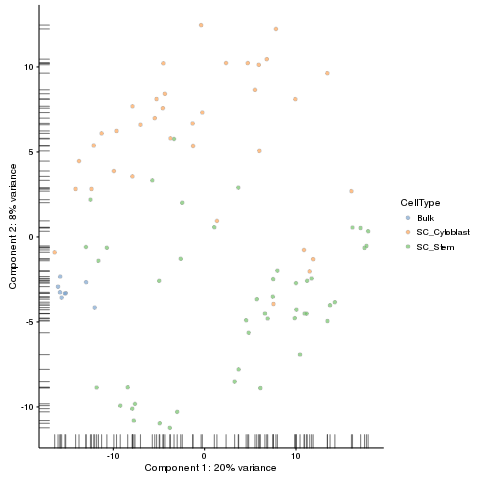

In [18]:
%%R
plotPCA(cdSceset, ncomponents = 2, colour_by = "CellType")

### PCA with top 500 most variable genes. The plot below plots 4 principle components with the dataset

In [19]:
%%R
rowVarsSorted <- exprs(cdSceset)[order(rowVars(exprs(cdSceset)), decreasing=TRUE),]
FinalPCAData <- t(rowVarsSorted[1:500,])
#FinalPCAData <- t(rowVarsSorted)
pcaPRComp <- prcomp(FinalPCAData)

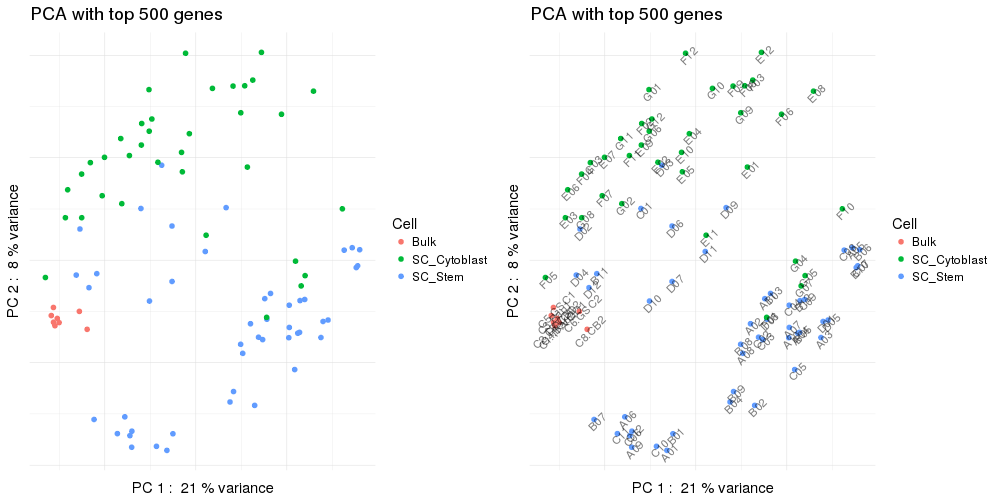

In [20]:
%%R -w 1000 -h 500
PCx=1
PCy=2
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
df$Cell=as.factor(MappingSummary$CellType)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with top 500 genes")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
#p <- p + geom_text(data=df,aes(label=colnames(exprs(cdSceset))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#p <- p + scale_colour_brewer(palette="Set1")

PCx=1
PCy=2
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
df$Cell=as.factor(MappingSummary$CellType)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with top 500 genes")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdSceset))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#p1 <- p1 + scale_colour_brewer(palette="Set1")
multiplot(p,p1, cols=2)

In [21]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

#pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1))
#rownames(pca_var_out) <- rownames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1)

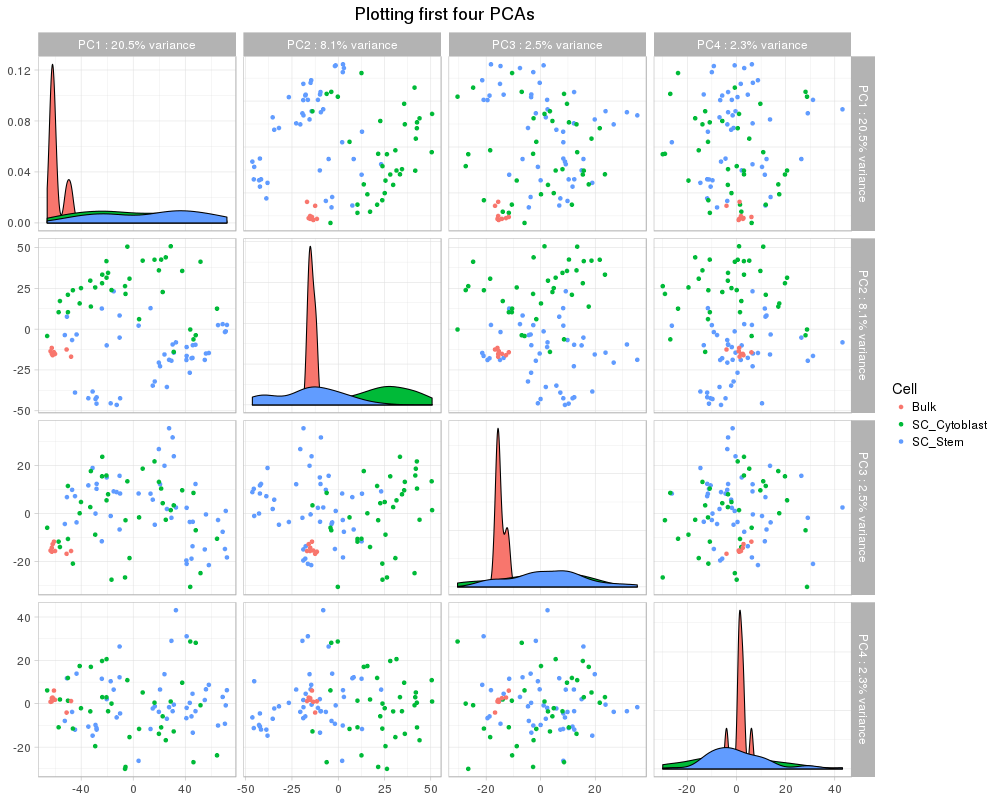

In [48]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=as.factor(MappingSummary$CellType)
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

Interestingly when I did the PCA with top 500 most variable genes the Bulk samples were clustering with single-cell. Although I was expecting them to cluster with one type of cells on all the PCs. Although in PC1 vs PC2 it clusters with SC_stem cells but looking closely one can see that we can divide the plot into two clusters and the Bulk cells are on the bottom cluster where there are more cytoblast cells. It is also the case for PC1 vs PC3 and PC4. But with other PCs it is not clearly evident.

Trying DBSCAN

In [214]:
%%R
library(dbscan)
rowVarsSorted <- exprs(cdSceset)[order(rowVars(exprs(cdSceset)), decreasing=TRUE),]
resDbscan <- dbscan(t(rowVarsSorted), eps=0.3, minPts=2)

In [215]:
%%R
resDbscan

DBSCAN clustering for 87 objects.
Parameters: eps = 0.3, minPts = 2
The clustering contains 0 cluster(s) and 87 noise points.

 0 
87 

Available fields: cluster, eps, minPts


### PCA with All Genes (Not just the top genes)

In [53]:
%%R
head(exprs(cdSceset))

              A01       A02       A03       A04      A05       A06       A07
a        7.137991  6.860475  0.000000  5.934046  0.00000  3.609997  8.356838
Abl      5.717979  7.918113  4.697514  3.013516  0.00000  3.609997  0.000000
abo      0.000000  0.000000  0.000000  8.814683  0.00000  9.419566  0.000000
Acph-1  10.507215  9.333327  8.592089  9.906444  0.00000  8.981430  8.699859
mAChR-A  0.000000  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000
Act5C   11.909849 11.944488 12.243147 12.511289 12.48288 11.767905 12.632358
              A08       A09      A10       A11       B01       B02       B03
a        7.273928  4.924616  9.23954  2.932738  3.968247  0.000000  0.000000
Abl      0.000000  3.971353  0.00000  0.000000  4.841742  6.850422  0.000000
abo      0.000000  7.003082  0.00000  8.699481  5.816365  0.000000  0.000000
Acph-1   9.366299  8.504782 10.81084 10.207177 10.039832 11.603863  7.693056
mAChR-A  0.000000  0.000000  0.00000  0.000000  0.000000  0.000000  0.000000

In [54]:
%%R
rowVarsSorted <- exprs(cdSceset)[order(rowVars(exprs(cdSceset)), decreasing=TRUE),]
#FinalPCAData <- t(rowVarsSorted[1:500,])
FinalPCAData <- t(rowVarsSorted)
pcaPRComp <- prcomp(FinalPCAData)

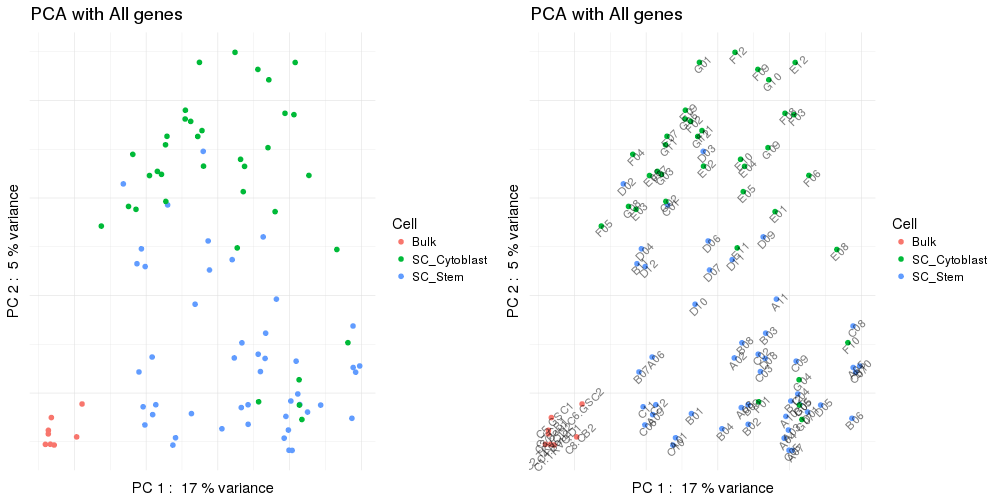

In [55]:
%%R -w 1000 -h 500
PCx=1
PCy=2
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
df$Cell=as.factor(MappingSummary$CellType)
p<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p<-p+ggtitle("PCA with All genes")
p<-p+geom_point(size = 2)
p<-p+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p<-p    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
#p <- p + geom_text(data=df,aes(label=colnames(exprs(cdSceset))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#p <- p + scale_colour_brewer(palette="Set1")

PCx=1
PCy=2
percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
df$Cell=as.factor(MappingSummary$CellType)
p1<-ggplot(df, aes_string(x="PCX",y ="PCY",color="Cell"))
p1<-p1+ggtitle("PCA with All genes")
p1<-p1+geom_point(size = 2)
p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
p1<-p1    + ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.text.x      = element_blank(),
           axis.text.y      = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
p1<-p1 + geom_text(data=df,aes(label=colnames(exprs(cdSceset))),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
#p1 <- p1 + scale_colour_brewer(palette="Set1")
multiplot(p,p1, cols=2)

In [56]:
%%R
nmax = 10
if(dim(pcaPRComp$x)[1] < 10){ nmax = dim(pcaPRComp$x)[1] }
txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
pca_var = pcaPRComp$sdev ^ 2
pca_var_percent <- 100 * pca_var / sum(pca_var)
pca_var_percent_first10 <- NA * pca_var
pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

#pca_corr_reads <- apply(pcaPRComp$x,2,function(x) cor(x,report_sub$Assigned))
    
pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1))
#rownames(pca_var_out) <- rownames(pcaPRComp$x)
colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1)

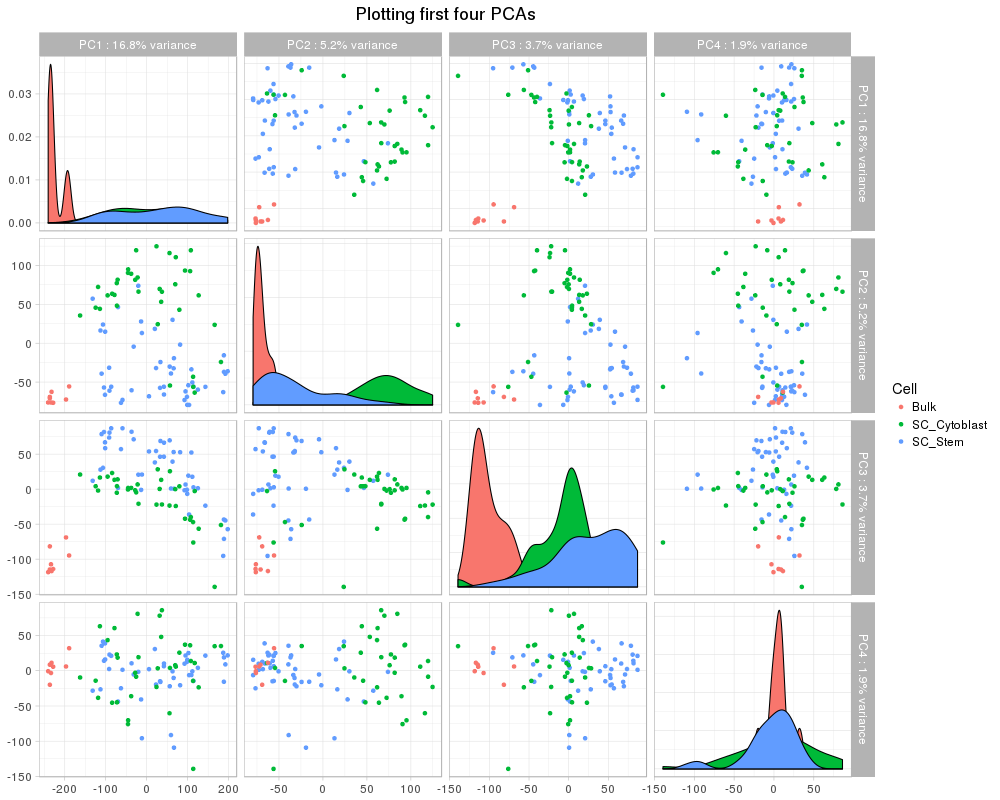

In [57]:
%%R -w 1000 -h 800
# Set the number of columns you like to display
nColToDisplay = 4
df <- as.data.frame(pcaPRComp$x)
df$Cell=as.factor(MappingSummary$CellType)
p <- ggpairs(df, columns=1:nColToDisplay, upper=list(continuous="points"), 
             title='Plotting first four PCAs', 
             mapping = aes_string(color="Cell"),
             legend = c(1,nColToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nColToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nColToDisplay], '% variance')))+
    theme_light(base_size=15)+     
    theme(plot.title = element_text(hjust = 0.5))
    
print(p)

When I take all the genes clearly the Bulk stays seperately. As the data is normalized clearly there is some difference between single-cell and Bulk data. A __Differential Expression__ analysis between these two catagories would be interesting to see.

## Scatter plot

Now I do a simple scatter plot to see the relationship between Single-cell and Bulk data. For this plot I calcualted the average for each of the genes across all the single cells and also sperately calcualted the average for all the genes across all the bulks. Then I plotted the averages as scatter plot.

In [58]:
%%R
cdSCAverage <- rowMeans(exprs(cdSceset)[,1:83])
cdBulkAverage <- rowMeans(exprs(cdSceset)[,84:87])
cdAverage <- data.frame(SC=cdSCAverage, Bulk=cdBulkAverage)

In [59]:
%%R
smoothScatter(cdAverage$SC, cdAverage$BULK, xlab=expression(Log[10]~"Average Single_cell CPM"))


Error in linbin2D(x, gpoints1, gpoints2) : object 'F_lbtwod' not found


/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

Error in linbin2D(x, gpoints1, gpoints2) : object 'F_lbtwod' not found




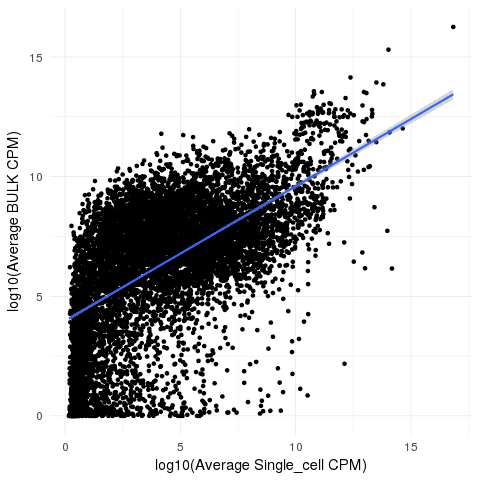

In [60]:
%%R
library(RColorBrewer)
p1 <- ggplot(cdAverage, aes(x =SC, y = Bulk))
p1 <- p1 + geom_point() + geom_smooth(method = "lm", se = TRUE)
p1<-p1 + xlab("log10(Average Single_cell CPM)")
p1<-p1 + ylab("log10(Average BULK CPM)")+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
#p1 <- p1 + stat_density_2d(aes(fill = ..level..), geom = "polygon")
#p1 <- p1 + geom_hex(aes(SC, Bulk), bins = 80) +
         scale_fill_gradientn("", colours = rev(rainbow(10, end = 4/6)))


print(p1)

Same plot but showing the density of the counts

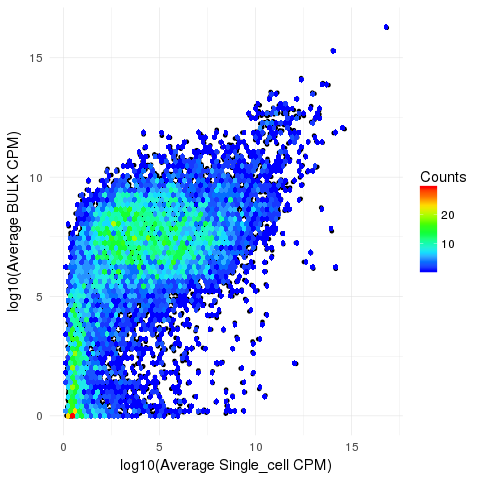

In [61]:
%%R
library(RColorBrewer)
p1 <- ggplot(cdAverage, aes(x =SC, y = Bulk))
p1 <- p1 + geom_point()
p1<-p1 + xlab("log10(Average Single_cell CPM)")
p1<-p1 + ylab("log10(Average BULK CPM)")+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
#p1 <- p1 + stat_density_2d(aes(fill = ..level..), geom = "polygon")
p1 <- p1 + geom_hex(aes(SC, Bulk), bins = 70) +
         scale_fill_gradientn("Counts", colours = rev(rainbow(10, end = 4/6)))


print(p1)

Point desnity again...

In [62]:
%%R
df <- data.frame(x = cdAverage$SC, y = cdAverage$Bulk,
  d = densCols(cdAverage$SC, cdAverage$Bulk, colramp = colorRampPalette(rev(rainbow(10, end = 4/6)))))
p <- ggplot(df) +
    geom_point(aes(x, y, col = d), size = 1) +
    scale_color_identity() +
    theme_bw()
print(p)


Error in linbin2D(x, gpoints1, gpoints2) : object 'F_lbtwod' not found


It is clear that the regression line does not fit that well. So we now try to see a non-linear regression

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

`geom_smooth()` using method = 'gam'




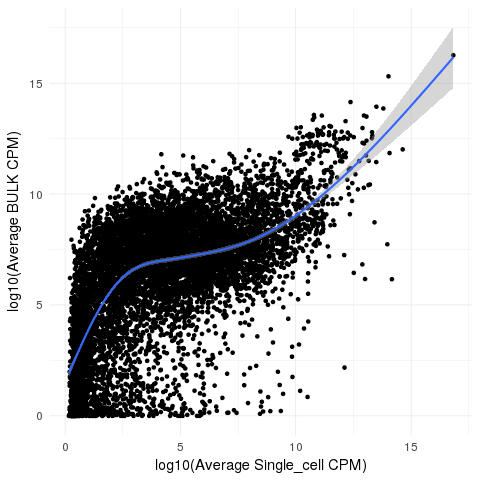

In [63]:
%%R
p1 <- qplot(SC, Bulk, data=cdAverage, geom = c("point", "smooth")) 
p1<-p1 + xlab("log10(Average Single_cell CPM)")
p1<-p1 + ylab("log10(Average BULK CPM)")+
theme_light(base_size=15) +
     theme(strip.background = element_blank(),
           strip.text.x     = element_blank(),
           axis.ticks       = element_blank(),
           axis.line        = element_blank(),
           panel.border     = element_blank())
print(p1)

__Discussion:__
So there is a clear non-linar relationship, indicating that for some genes single-cell have higher expression and for some Bulk has higher expression. If we look at the regression line, at the beginning it is more steaf indicating that the  BULK have higher expression. But this then gets more stiff and the Single-cell value increases. This is quite interesting as for some genes single-cell is high and for some gene bulk is high. 

__Note for Myself:__
I am not sure about the experimental condition for the BULK data. So verifying this with experimental condition might lead to more analysis.


### Correlation heatmap

I calculate the pearson correlation among the cells. The value inside the plots in the first heatmap shows the correlation value.

In [64]:
%%R
M <- cor(exprs(cdSceset))

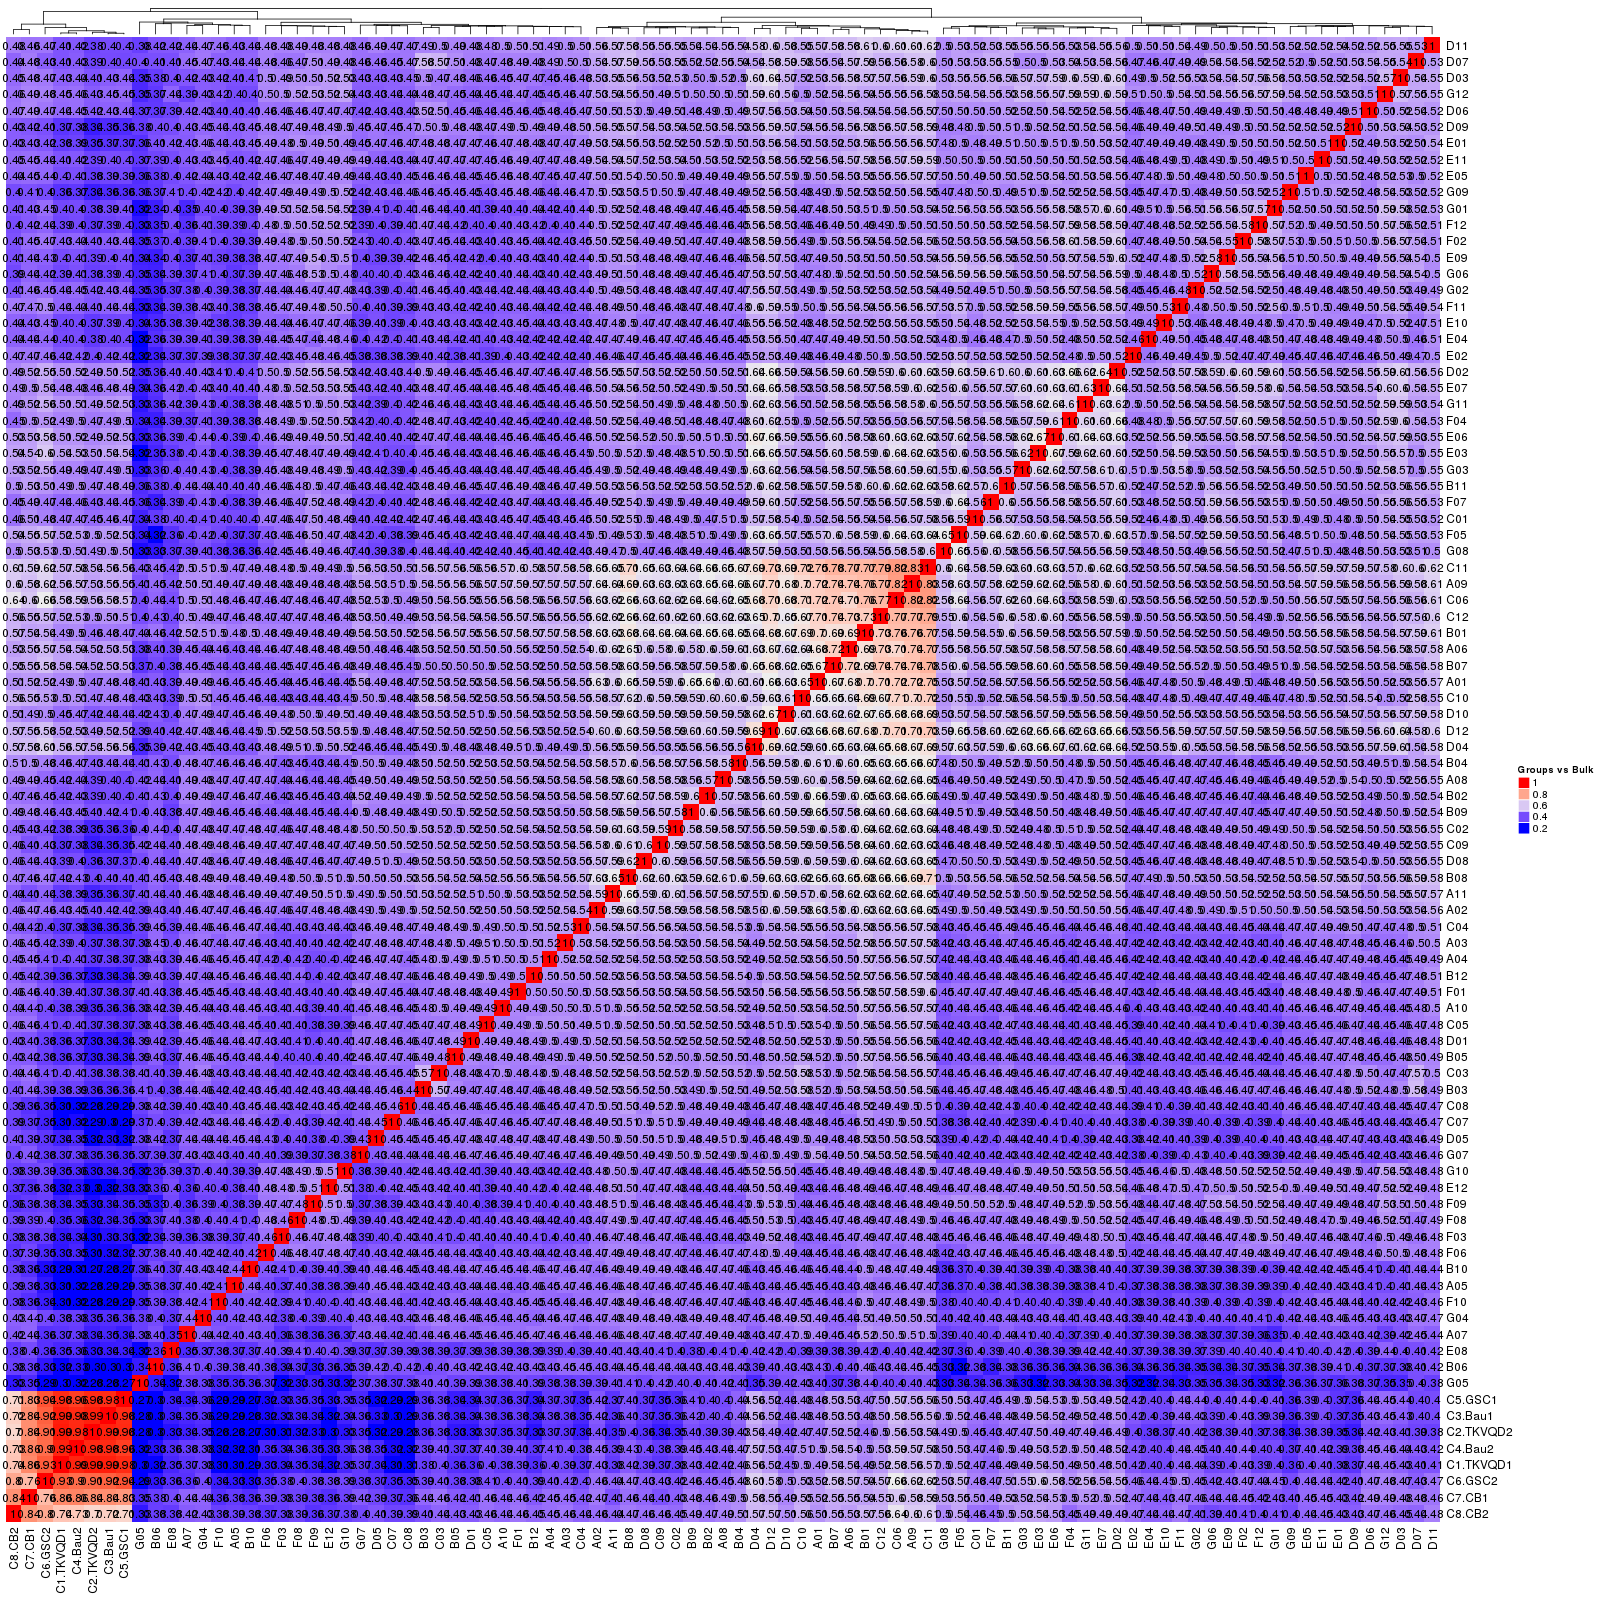

In [65]:
%%R -w 1600 -h 1600
Heatmap(M,clustering_distance_columns = "euclidean",
        clustering_method_rows = "complete",
        name='Groups vs Bulk',
        show_row_dend = FALSE,
       cell_fun = function(j, i, x, y, w, h, col) {
        grid.text(round(M[i, j],digits=2), x, y)
    })

The same plot but for ease with visibility I am now doing a plot where the pie shows the correlation.

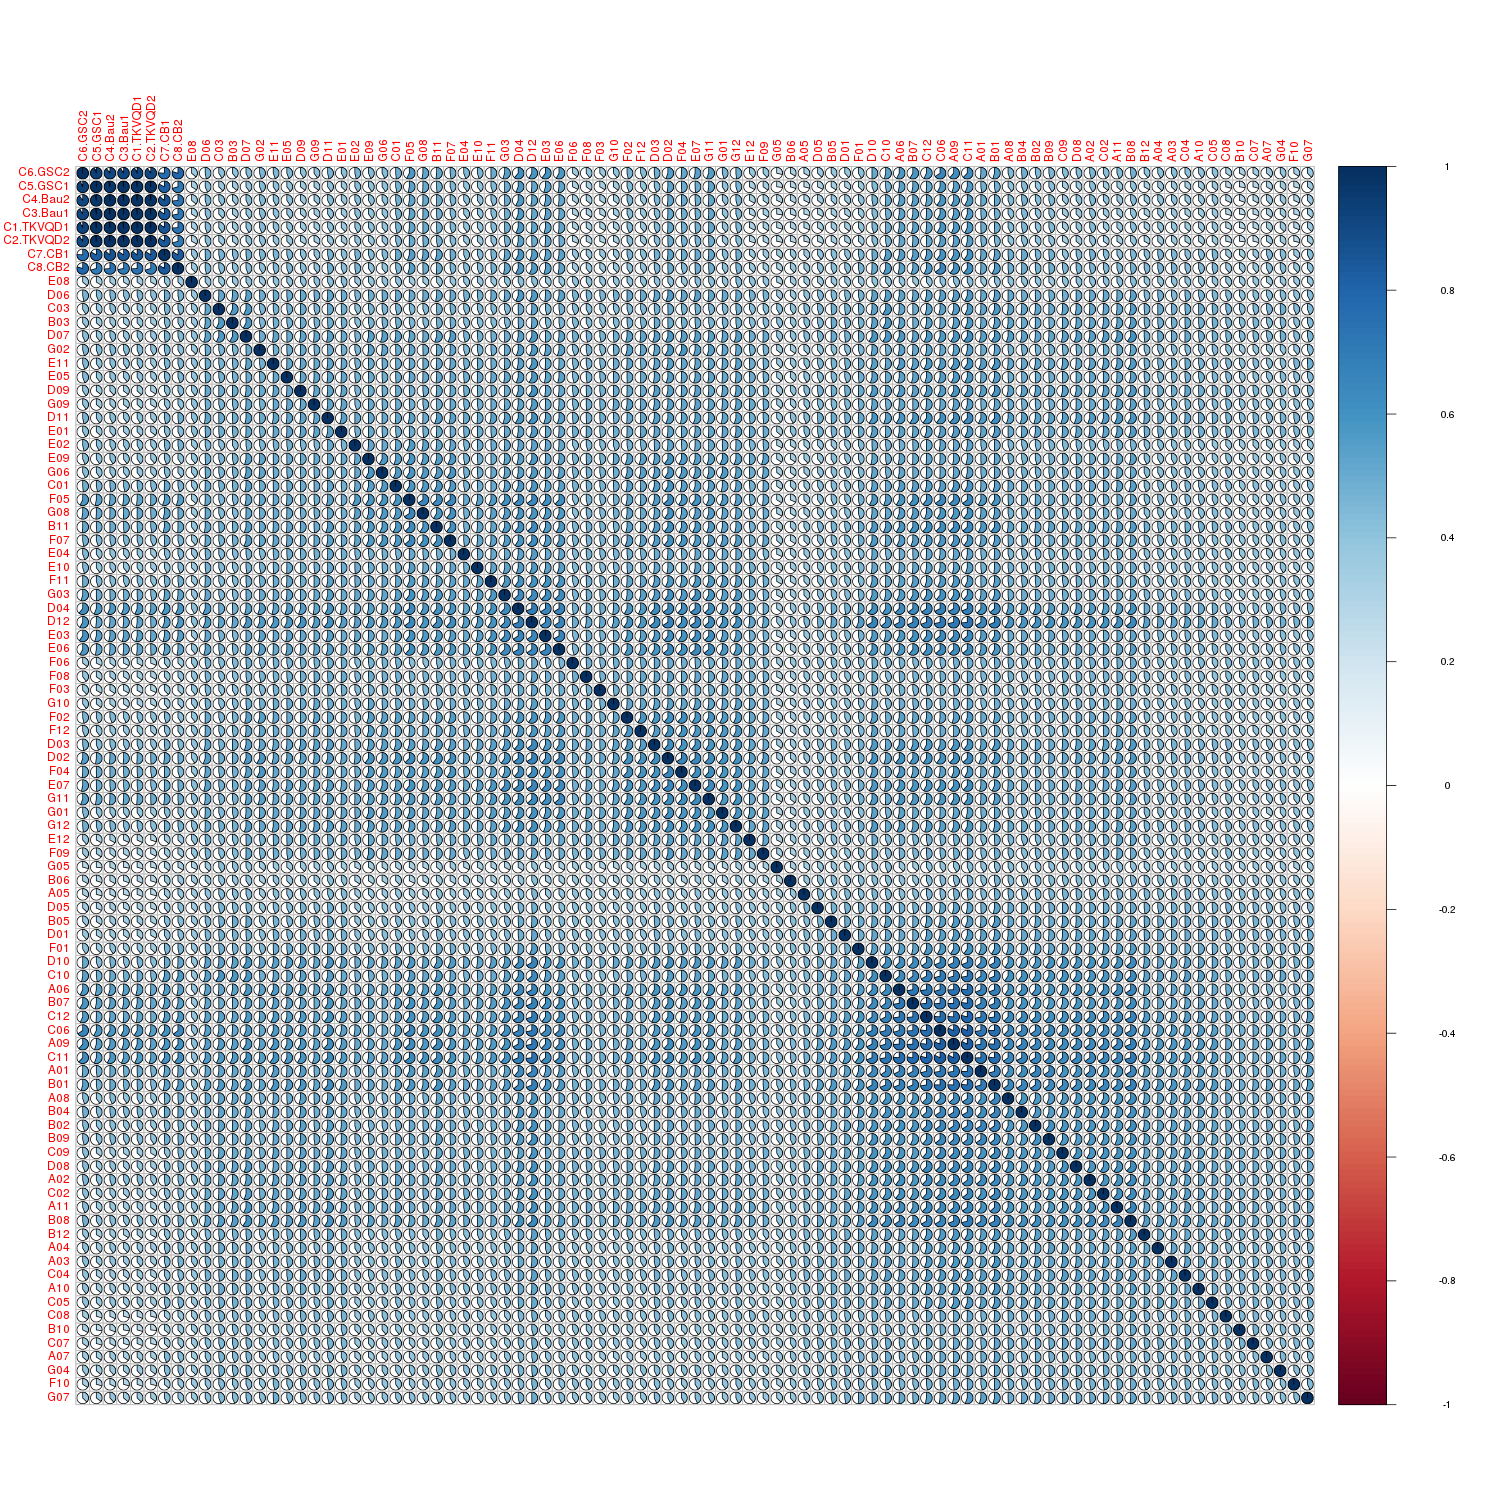

In [66]:
%%R -w 1500 -h 1500
corrplot(M, order="hclust", method="pie")

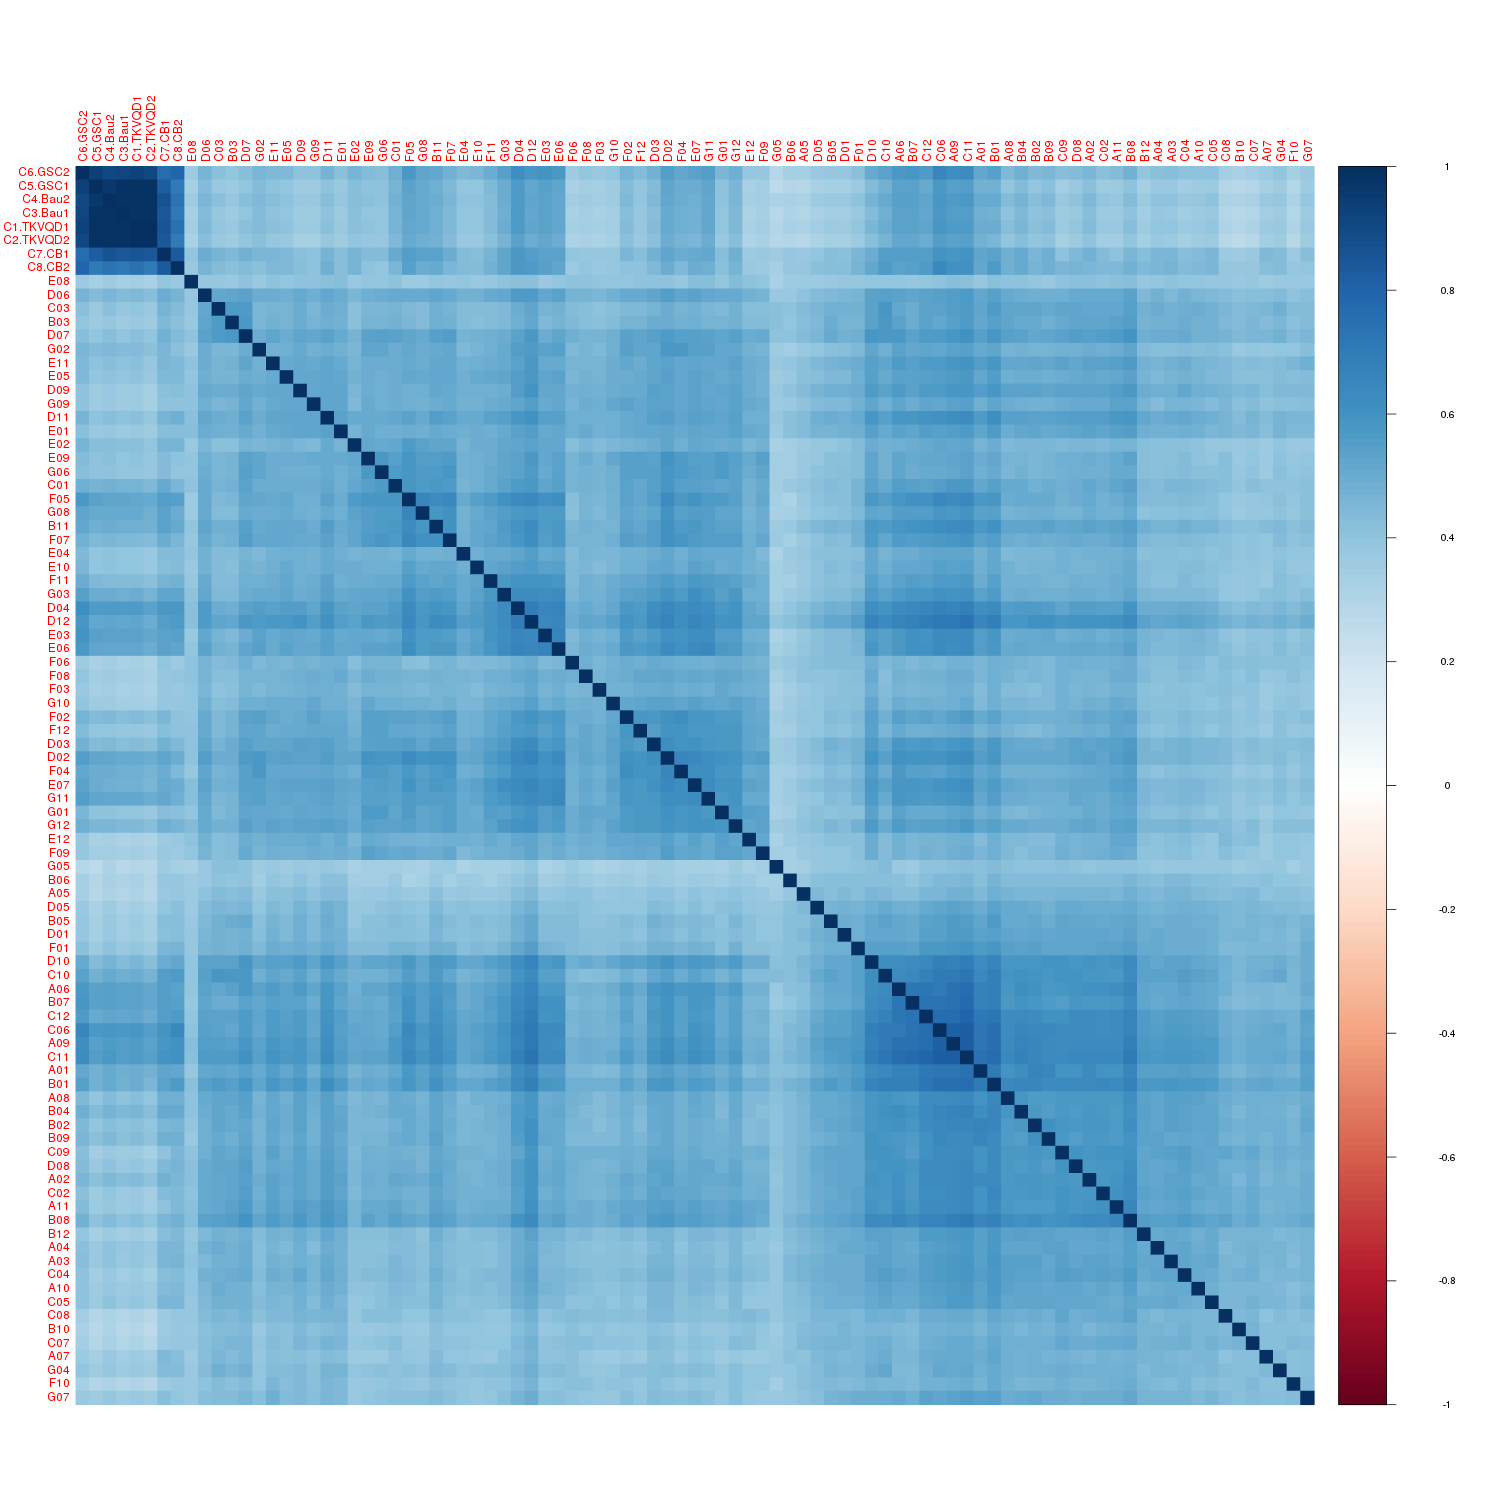

In [67]:
%%R -w 1500 -h 1500
corrplot(M, order="hclust", method="color")

## Differential Expression analysis
I will now run a differential expression analysis. For the time being I am running DESeq2. But it would be good also to run SCDE.

In [69]:
%%R
colnames(cdCombined)[1:83] <- paste0('SC_',colnames(cdCombined)[1:83])
colnames(cdCombined)[84:91] <- paste0('Bulk_',colnames(cdCombined)[84:91])
colnames(cdCombined)

 [1] "SC_A01"         "SC_A02"         "SC_A03"         "SC_A04"        
 [5] "SC_A05"         "SC_A06"         "SC_A07"         "SC_A08"        
 [9] "SC_A09"         "SC_A10"         "SC_A11"         "SC_B01"        
[13] "SC_B02"         "SC_B03"         "SC_B04"         "SC_B05"        
[17] "SC_B06"         "SC_B07"         "SC_B08"         "SC_B09"        
[21] "SC_B10"         "SC_B11"         "SC_B12"         "SC_C01"        
[25] "SC_C02"         "SC_C03"         "SC_C04"         "SC_C05"        
[29] "SC_C06"         "SC_C07"         "SC_C08"         "SC_C09"        
[33] "SC_C10"         "SC_C11"         "SC_C12"         "SC_D01"        
[37] "SC_D02"         "SC_D03"         "SC_D04"         "SC_D05"        
[41] "SC_D06"         "SC_D07"         "SC_D08"         "SC_D09"        
[45] "SC_D10"         "SC_D11"         "SC_D12"         "SC_E01"        
[49] "SC_E02"         "SC_E03"         "SC_E04"         "SC_E05"        
[53] "SC_E06"         "SC_E07"         "SC_E08"    

In [70]:
%%R
countsTableTrim <- cdCombined
celltype <- factor(gsub("(SC|Bulk).*", "\\1", colnames(cdCombined)),levels=c("SC", "Bulk"))
table(celltype)
myNames <- colnames(countsTableTrim)
colDataNames<-data.frame(sampleName=myNames, celltype=celltype)
des<-formula(~celltype)
#DESeqDataSet
ddsHTSeq<-DESeqDataSetFromMatrix(countsTableTrim, colData=colDataNames, design=des, ignoreRank = FALSE)
ddsHTSeq<-DESeq(ddsHTSeq,betaPrior=FALSE)
##look at contrasts done
resultsNames(ddsHTSeq)

/home/baker/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:

-- replacing outliers and refitting for 653 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)




[1] "Intercept"           "celltype_Bulk_vs_SC"


In [71]:
%%R
res=results (ddsHTSeq, name="celltype_Bulk_vs_SC", independentFiltering = FALSE)
write.csv(res,"DESeq_celltype_Bulk_vs_SC_ADDED_BULK.csv")

In [72]:
%%R
resSorted <- res[order(res$padj,decreasing=FALSE), ]

We now try to see number of differentially expressed genes between Bulk and SC that have FDR less than 0.005

In [73]:
%%R
print(paste0('Number of Genes Differentially Expressed with FDR < 0.005: ',sum(resSorted$padj < 0.005, na.rm=TRUE)))

[1] "Number of Genes Differentially Expressed with FDR < 0.005: 778"


510 genes are differentially expressed between Bulk and SC data. I will now print the first 100 genes in __Bulk_vs_SC__

In [75]:
%%R

#as.data.frame(resSorted)[1:100,c(2,6)]

NULL


__Note:__
I used DESeq2 here. However, DESeq2 was not meant for single-cell and might give higher False positives. I will also try SCDE for this analysis.

## Grouping the cells
We now do the analysis by grouping the cells as shown in the PAGODA analysis. There are three groups that came out from the PAGODA analysis. Two of it are regular GSC and CB cells but then there came a third unknown group. We would be interested to see how does this third group behave. As Scott reported third group that are classified as GSCs in all the PAGODA analyses but appear to express genes we know to be associated with differentiation and that are highly expressed by the CBs 

In [19]:
%%R
colnames(cdCombined)

 [1] "A01"       "A02"       "A03"       "A04"       "A05"       "A06"      
 [7] "A07"       "A08"       "A09"       "A10"       "A11"       "B01"      
[13] "B02"       "B03"       "B04"       "B05"       "B06"       "B07"      
[19] "B08"       "B09"       "B10"       "B11"       "B12"       "C01"      
[25] "C02"       "C03"       "C04"       "C05"       "C06"       "C07"      
[31] "C08"       "C09"       "C10"       "C11"       "C12"       "D01"      
[37] "D02"       "D03"       "D04"       "D05"       "D06"       "D07"      
[43] "D08"       "D09"       "D10"       "D11"       "D12"       "E01"      
[49] "E02"       "E03"       "E04"       "E05"       "E06"       "E07"      
[55] "E08"       "E09"       "E10"       "E11"       "E12"       "F01"      
[61] "F02"       "F03"       "F04"       "F05"       "F06"       "F07"      
[67] "F08"       "F09"       "F10"       "F11"       "F12"       "G01"      
[73] "G02"       "G03"       "G04"       "G05"       "G06"       "G07"      

In [27]:
%%R -o GSC_Group_CellName,CB_Group_CellName,Unknown_Group_CellName
GSC_Group_CellName = colnames(cdCombined)[c(1:21,23,25:36,40,42,43,60,69,75,76,78)]
CB_Group_CellName = colnames(cdCombined)[c(37:39,49:57,59,61:68,70:74,77,79:83)]
Unknown_Group_CellName = colnames(cdCombined)[c(22,24,41,44:48,58)]

print(GSC_Group_CellName)
print(CB_Group_CellName)
print(Unknown_Group_CellName)


 [1] "A01" "A02" "A03" "A04" "A05" "A06" "A07" "A08" "A09" "A10" "A11" "B01"
[13] "B02" "B03" "B04" "B05" "B06" "B07" "B08" "B09" "B10" "B12" "C02" "C03"
[25] "C04" "C05" "C06" "C07" "C08" "C09" "C10" "C11" "C12" "D01" "D05" "D07"
[37] "D08" "F01" "F10" "G04" "G05" "G07"
 [1] "D02" "D03" "D04" "E02" "E03" "E04" "E05" "E06" "E07" "E08" "E09" "E10"
[13] "E12" "F02" "F03" "F04" "F05" "F06" "F07" "F08" "F09" "F11" "F12" "G01"
[25] "G02" "G03" "G06" "G08" "G09" "G10" "G11" "G12"
[1] "B11" "C01" "D06" "D09" "D10" "D11" "D12" "E01" "E11"


We now create three folders in the output directory and copy the BAM files for these three cells into the folder. We will then merge those cells to create a BULK from the cells. Then we will call htseq from the merged BAM files. 

In [57]:
dataFolder = '/home/baker/my-dpsf-scratch-share/Scott_Wilcockson_single_cell/output/'
BAM_output = dataFolder + 'STAR_output/'
GSC_output = dataFolder + 'GSC_Group/'
CB_output = dataFolder + 'CB_Group/'
Unknown_output = dataFolder + 'Unknown_Group/'

print(BAM_output)

/home/baker/my-dpsf-scratch-share/Scott_Wilcockson_single_cell/output/STAR_output/


In [65]:
for file in os.listdir(BAM_output):
    for i in range(0,len(GSC_Group_CellName)):
        if file.endswith(".bam") & file.startswith(GSC_Group_CellName[i]):
            #print(BAM_output+os.path.join(file))
            CopyCmd = 'cp ' + BAM_output+os.path.join(file)+ ' ' +GSC_output
            #print(CopyCmd)
            subprocess.call(CopyCmd, shell=True)


In [70]:
mergeCmd = 'samtools merge ' + GSC_output+ 'AllGSCMerged.bam '
for file in os.listdir(BAM_output):
    for i in range(0,len(GSC_Group_CellName)):
        if file.endswith(".bam") & file.startswith(GSC_Group_CellName[i]):
            #print(BAM_output+os.path.join(file))
            mergeCmd = mergeCmd + BAM_output+os.path.join(file) + ' '
#print(mergeCmd)
subprocess.call(mergeCmd, shell=True)

0

In [71]:
for file in os.listdir(BAM_output):
    for i in range(0,len(CB_Group_CellName)):
        if file.endswith(".bam") & file.startswith(CB_Group_CellName[i]):
            #print(BAM_output+os.path.join(file))
            CopyCmd = 'cp ' + BAM_output+os.path.join(file)+ ' ' +CB_output
            #print(CopyCmd)
            subprocess.call(CopyCmd, shell=True)

In [74]:
mergeCmd = 'samtools merge ' + CB_output+ 'AllCBMerged.bam '
for file in os.listdir(BAM_output):
    for i in range(0,len(CB_Group_CellName)):
        if file.endswith(".bam") & file.startswith(CB_Group_CellName[i]):
            #print(BAM_output+os.path.join(file))
            mergeCmd = mergeCmd + BAM_output+os.path.join(file) + ' '
#print(mergeCmd)
subprocess.call(mergeCmd, shell=True)

0

In [73]:
for file in os.listdir(BAM_output):
    for i in range(0,len(Unknown_Group_CellName)):
        if file.endswith(".bam") & file.startswith(Unknown_Group_CellName[i]):
            #print(BAM_output+os.path.join(file))
            CopyCmd = 'cp ' + BAM_output+os.path.join(file)+ ' ' +Unknown_output
            #print(CopyCmd)
            subprocess.call(CopyCmd, shell=True)

In [76]:
mergeCmd = 'samtools merge ' + Unknown_output+ 'AllUnknownMerged.bam '
for file in os.listdir(BAM_output):
    for i in range(0,len(Unknown_Group_CellName)):
        if file.endswith(".bam") & file.startswith(Unknown_Group_CellName[i]):
            #print(BAM_output+os.path.join(file))
            mergeCmd = mergeCmd + BAM_output+os.path.join(file) + ' '
#print(mergeCmd)
subprocess.call(mergeCmd, shell=True)

0